### Imports and load data 

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [2]:
# Load the datasets
df_historical = pd.read_parquet('historical_orders.parquet')
df_august_total_sales = pd.read_parquet('august_total_sales.parquet')
df_august_with_missing = pd.read_parquet('august_with_missing_order_days.parquet')

# Question 1

## EDA

#### historical 

In [3]:
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   account_id          object 
 1   order_date          object 
 2   transaction_amount  float64
dtypes: float64(1), object(2)
memory usage: 262.4+ MB


In [4]:
# Check for missing data in df_historical
print("Missing values in df_historical:")
print(df_historical.isnull().sum())


Missing values in df_historical:
account_id            0
order_date            0
transaction_amount    0
dtype: int64


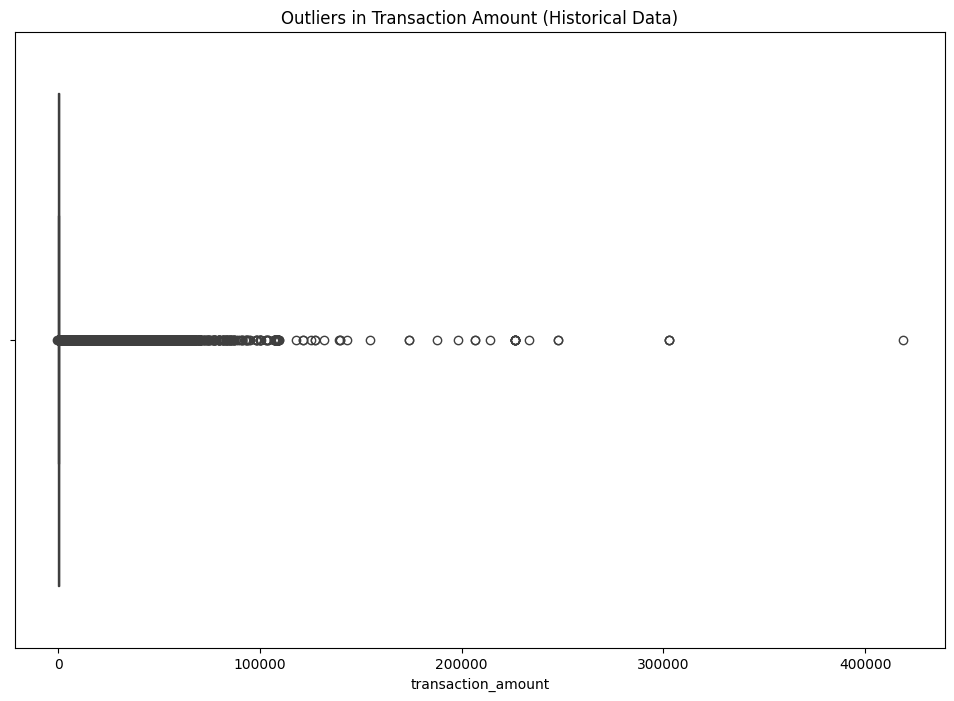

In [5]:
# Outliers in df_historical (transaction amounts)
plt.figure(figsize=(12, 8))
sns.boxplot(x=df_historical['transaction_amount'])
plt.title("Outliers in Transaction Amount (Historical Data)")
plt.show()

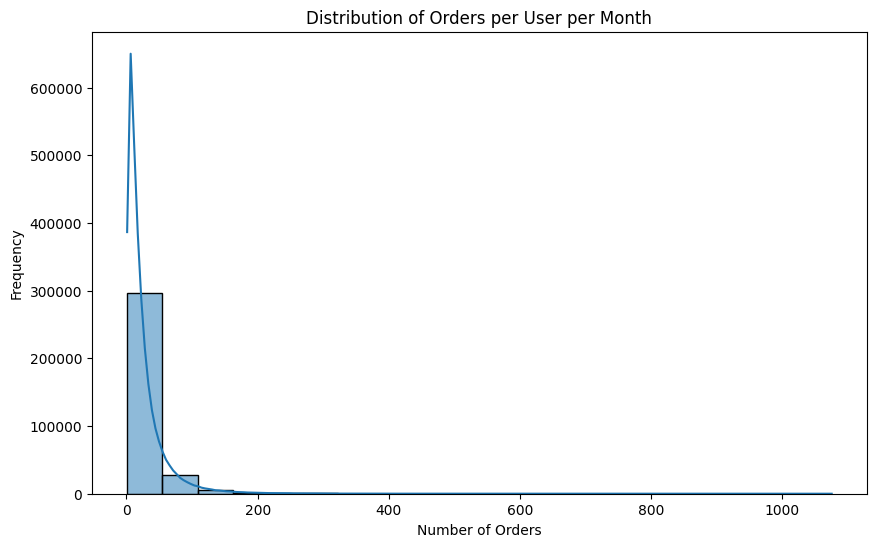

In [6]:
# Convert order_date to datetime
df_historical['order_date'] = pd.to_datetime(df_historical['order_date'])

# Create a 'month' column
df_historical['order_month'] = df_historical['order_date'].dt.month

# Calculate number of orders per user per month
orders_per_user_month = df_historical.groupby(['account_id', 'order_month'])['order_date'].count().reset_index()
orders_per_user_month.columns = ['account_id', 'order_month', 'num_orders']

# Visualizing the distribution of orders per user in a month
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_user_month['num_orders'], kde=True, bins=20)
plt.title("Distribution of Orders per User per Month")
plt.xlabel("Number of Orders")
plt.ylabel("Frequency")
plt.show()


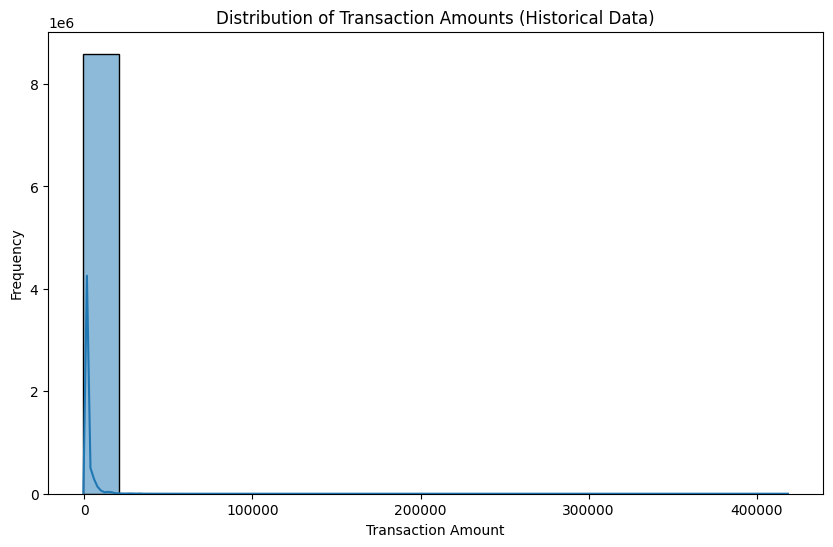

In [7]:
# Distribution of transaction amounts for historical orders
plt.figure(figsize=(10, 6))
sns.histplot(df_historical['transaction_amount'], kde=True, bins=20)
plt.title("Distribution of Transaction Amounts (Historical Data)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

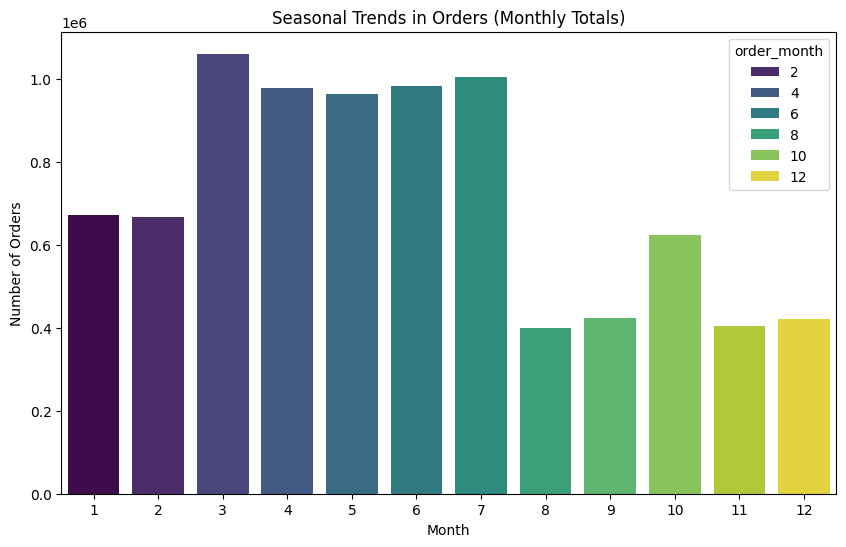

In [8]:
# Seasonal order trends
df_historical['order_month'] = df_historical['order_date'].dt.month
monthly_orders = df_historical.groupby('order_month').size().reset_index(name='num_orders')

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_orders, x='order_month', y='num_orders', palette='viridis', hue= "order_month" )
plt.title("Seasonal Trends in Orders (Monthly Totals)")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()

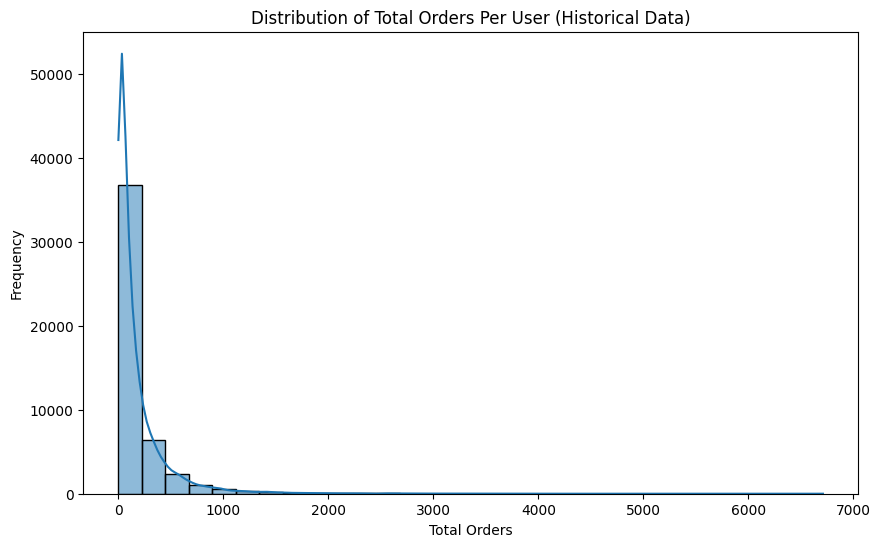

In [9]:
# Orders per user (overall)
orders_per_user = df_historical.groupby('account_id')['order_date'].count().reset_index(name='total_orders')

# Plot distribution of total orders per user
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_user['total_orders'], bins=30, kde=True)
plt.title("Distribution of Total Orders Per User (Historical Data)")
plt.xlabel("Total Orders")
plt.ylabel("Frequency")
plt.show()

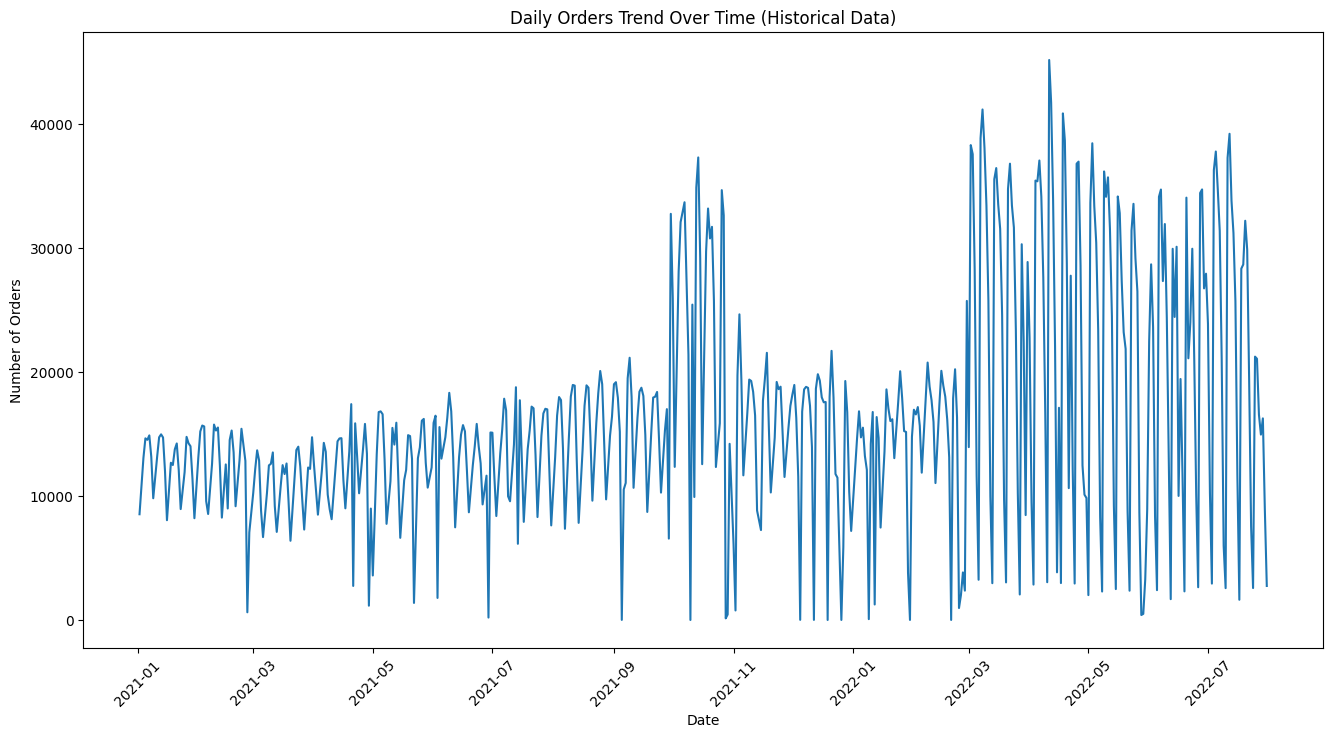

In [10]:
# Aggregating orders by date to see trends over time
daily_orders = df_historical.groupby('order_date').size().reset_index(name='num_orders')

# Plotting the time series of daily orders
plt.figure(figsize=(16, 8))
sns.lineplot(x='order_date', y='num_orders', data=daily_orders)
plt.title("Daily Orders Trend Over Time (Historical Data)")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


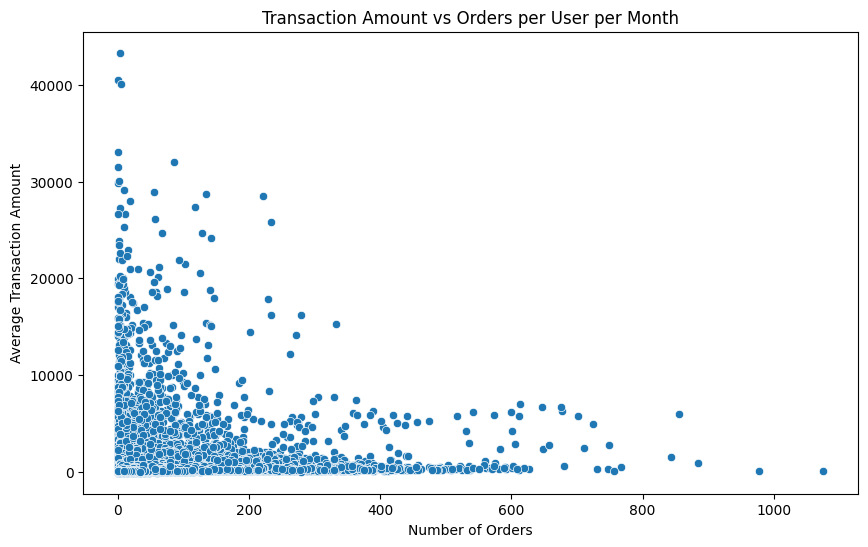

Correlation between number of orders and transaction amount: 0.10414568564255766


In [11]:
# Calculate average transaction amount per user per month
avg_transactions = df_historical.groupby(['account_id', 'order_month'])['transaction_amount'].mean().reset_index()

# Merge with orders per user per month
merged_data = pd.merge(orders_per_user_month, avg_transactions, on=['account_id', 'order_month'], how='left')

# Scatter plot to visualize correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='num_orders', y='transaction_amount')
plt.title("Transaction Amount vs Orders per User per Month")
plt.xlabel("Number of Orders")
plt.ylabel("Average Transaction Amount")
plt.show()

# Compute correlation
correlation = merged_data['num_orders'].corr(merged_data['transaction_amount'])
print(f"Correlation between number of orders and transaction amount: {correlation}")


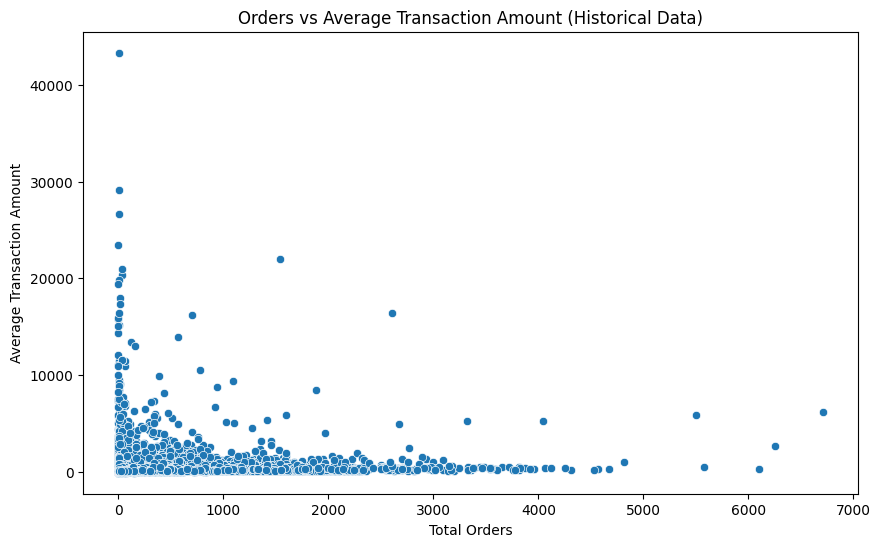

Correlation between total of orders and transaction amount: 0.08583303879225569


In [12]:
# Correlation between transaction amounts and frequency
user_avg_transaction = df_historical.groupby('account_id')['transaction_amount'].mean().reset_index()
merged_data = pd.merge(orders_per_user, user_avg_transaction, on='account_id')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='total_orders', y='transaction_amount')
plt.title("Orders vs Average Transaction Amount (Historical Data)")
plt.xlabel("Total Orders")
plt.ylabel("Average Transaction Amount")
plt.show()

# Compute correlation
correlation = merged_data['total_orders'].corr(merged_data['transaction_amount'])
print(f"Correlation between total of orders and transaction amount: {correlation}")

#### August_total_sales

In [13]:
df_august_total_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       32944 non-null  object 
 1   total_transaction_amount_august  32944 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.9+ KB


In [14]:
# Check for missing data in df_august_total_sales
print("\nMissing values in df_august_total_sales:")
print(df_august_total_sales.isnull().sum())


Missing values in df_august_total_sales:
account_id                         0
total_transaction_amount_august    0
dtype: int64


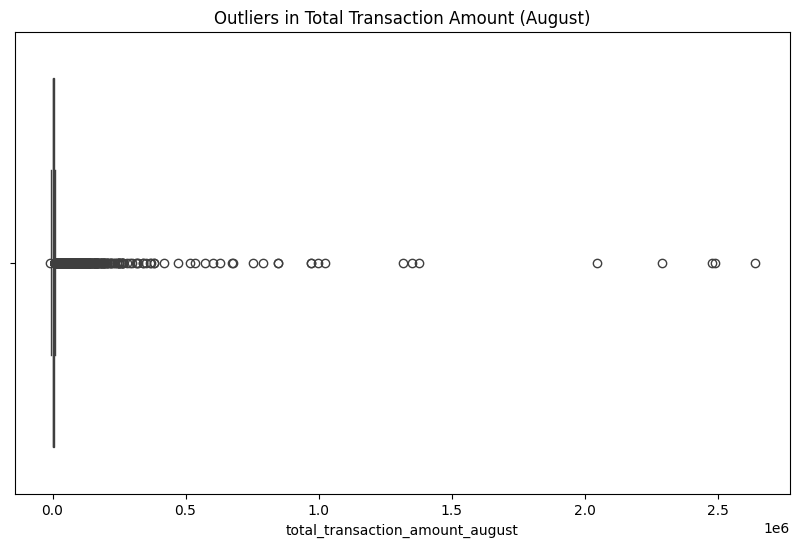

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_august_total_sales['total_transaction_amount_august'])
plt.title("Outliers in Total Transaction Amount (August)")
plt.show()

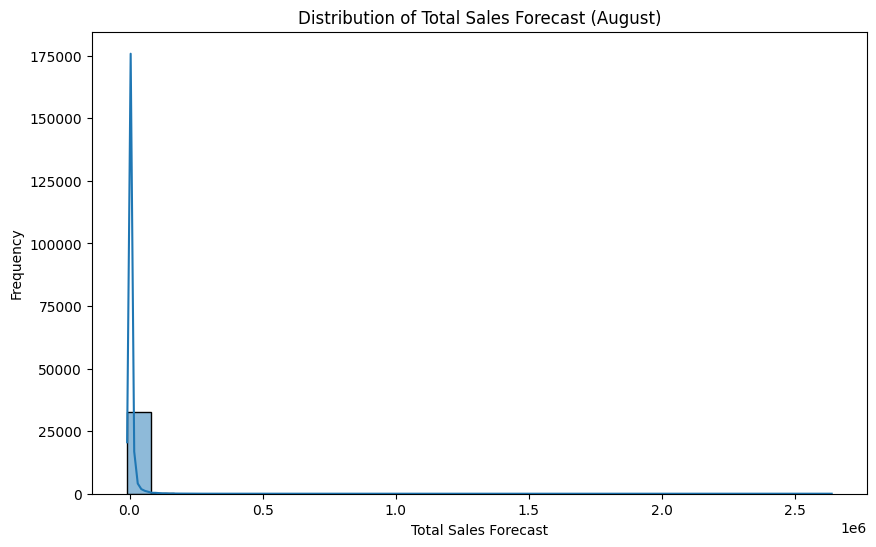

In [16]:
# Distribution of total sales forecast
plt.figure(figsize=(10, 6))
sns.histplot(df_august_total_sales['total_transaction_amount_august'], bins=30, kde=True)
plt.title("Distribution of Total Sales Forecast (August)")
plt.xlabel("Total Sales Forecast")
plt.ylabel("Frequency")
plt.show()

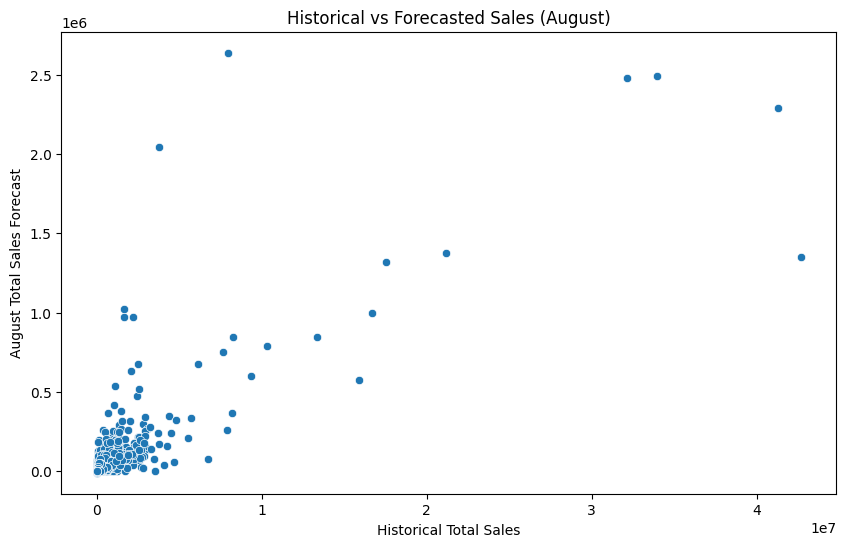

Correlation between historical and August forecasted sales: 0.8109958364028365


In [17]:
historical_total = df_historical.groupby('account_id')['transaction_amount'].sum().reset_index()
historical_total.columns = ['account_id', 'historical_total']

august_total_with_history = pd.merge(df_august_total_sales, historical_total, on='account_id', how='left')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=august_total_with_history, x='historical_total', y='total_transaction_amount_august')
plt.title("Historical vs Forecasted Sales (August)")
plt.xlabel("Historical Total Sales")
plt.ylabel("August Total Sales Forecast")
plt.show()

# Correlation coefficient
correlation = august_total_with_history['historical_total'].corr(august_total_with_history['total_transaction_amount_august'])
print(f"Correlation between historical and August forecasted sales: {correlation}")

#### august_with_missing

In [18]:
df_august_with_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317735 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_id          317735 non-null  object 
 1   order_date          304297 non-null  object 
 2   transaction_amount  304297 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


In [19]:
# Check for missing data in df_august_with_missing
print("\nMissing values in df_august_with_missing:")
print(df_august_with_missing.isnull().sum())



Missing values in df_august_with_missing:
account_id                0
order_date            13438
transaction_amount    13438
dtype: int64


In [20]:
df_august_with_missing = df_august_with_missing.dropna(subset=['order_date', 'transaction_amount'], how='all')

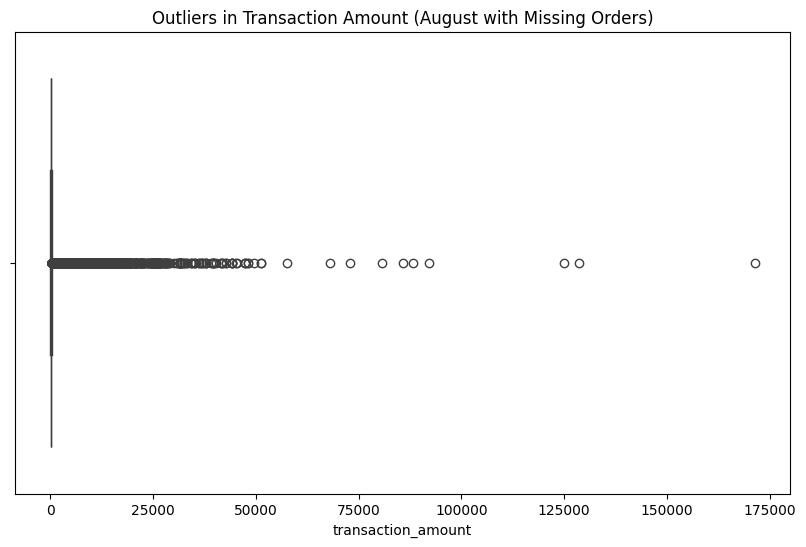

In [21]:
# Outliers in df_august_with_missing (transaction amounts)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_august_with_missing['transaction_amount'])
plt.title("Outliers in Transaction Amount (August with Missing Orders)")
plt.show()

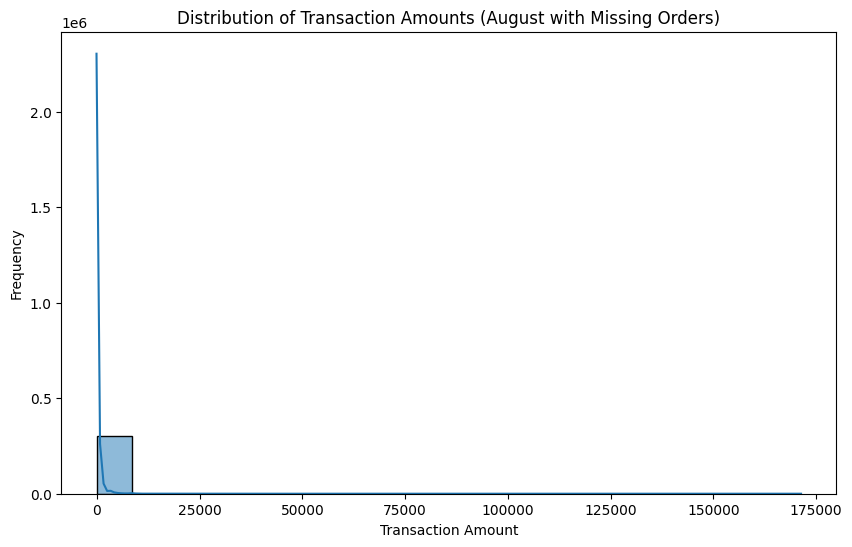

In [22]:
# Distribution of transaction amounts for August (with missing orders)
plt.figure(figsize=(10, 6))
sns.histplot(df_august_with_missing['transaction_amount'], kde=True, bins=20)
plt.title("Distribution of Transaction Amounts (August with Missing Orders)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

- Order patterns over days in August.

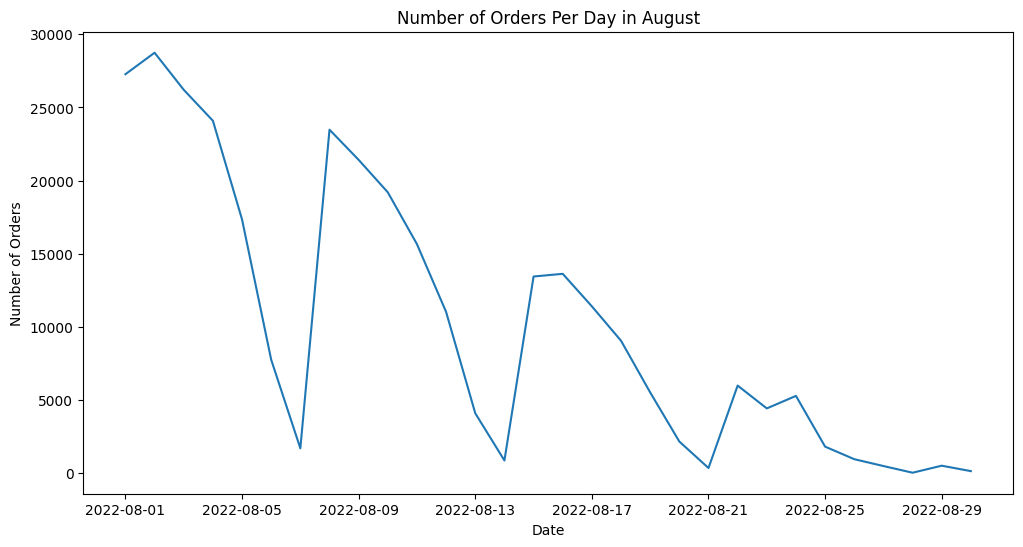

In [23]:
# Convert order_date to datetime for analysis
df_august_with_missing['order_date'] = pd.to_datetime(df_august_with_missing['order_date'], errors='coerce')

# Orders per day (count)
daily_orders_august = df_august_with_missing.groupby('order_date').size().reset_index(name='num_orders')

# Plot daily order counts
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_orders_august, x='order_date', y='num_orders')
plt.title("Number of Orders Per Day in August")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

In [24]:
# Analyze missing patterns
missing_dates = df_august_with_missing[df_august_with_missing['order_date'].isnull()]
print(f"Missing rows by account_id: {missing_dates['account_id'].value_counts().head()}")

Missing rows by account_id: Series([], Name: count, dtype: int64)


In [25]:
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   account_id          object        
 1   order_date          datetime64[ns]
 2   transaction_amount  float64       
 3   order_month         int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(1)
memory usage: 295.2+ MB


In [26]:
# Check for missing data in df_historical
print("Missing values in df_historical:")
print(df_historical.isnull().sum())


Missing values in df_historical:
account_id            0
order_date            0
transaction_amount    0
order_month           0
dtype: int64


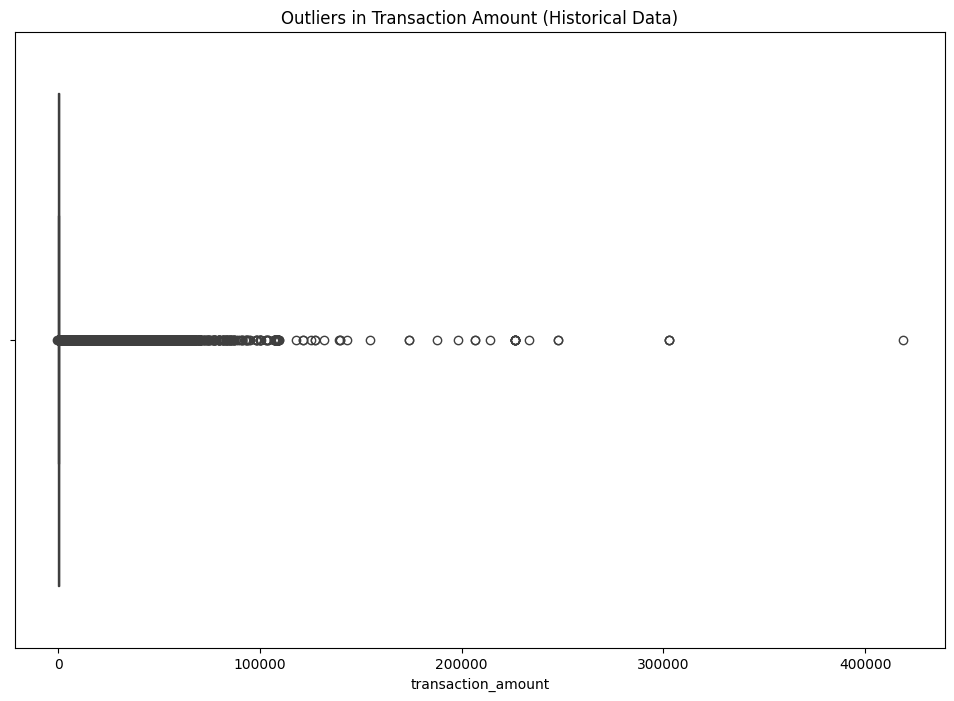

In [27]:
# Outliers in df_historical (transaction amounts)
plt.figure(figsize=(12, 8))
sns.boxplot(x=df_historical['transaction_amount'])
plt.title("Outliers in Transaction Amount (Historical Data)")
plt.show()

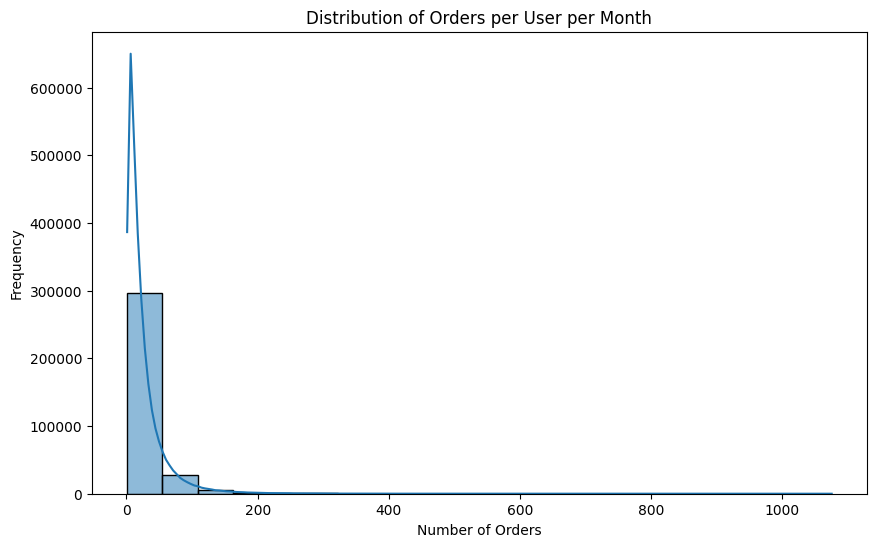

In [28]:
# Convert order_date to datetime
df_historical['order_date'] = pd.to_datetime(df_historical['order_date'])

# Create a 'month' column
df_historical['order_month'] = df_historical['order_date'].dt.month

# Calculate number of orders per user per month
orders_per_user_month = df_historical.groupby(['account_id', 'order_month'])['order_date'].count().reset_index()
orders_per_user_month.columns = ['account_id', 'order_month', 'num_orders']

# Visualizing the distribution of orders per user in a month
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_user_month['num_orders'], kde=True, bins=20)
plt.title("Distribution of Orders per User per Month")
plt.xlabel("Number of Orders")
plt.ylabel("Frequency")
plt.show()


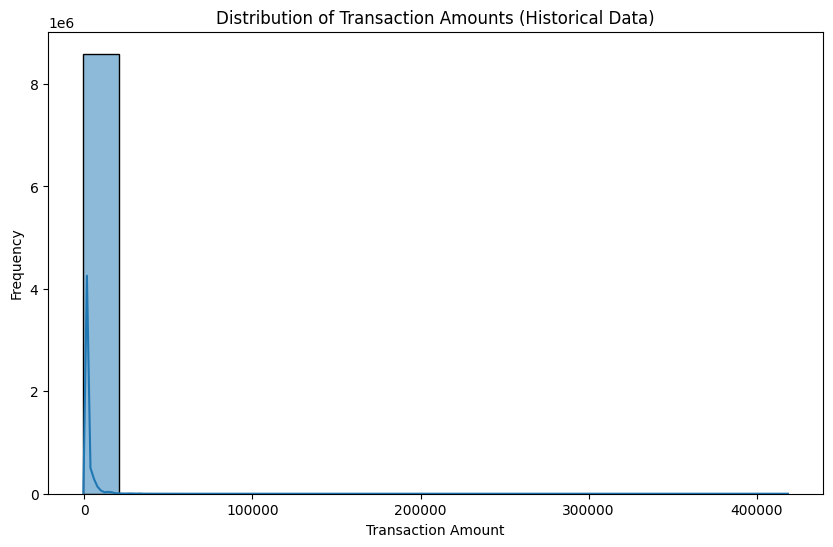

In [29]:
# Distribution of transaction amounts for historical orders
plt.figure(figsize=(10, 6))
sns.histplot(df_historical['transaction_amount'], kde=True, bins=20)
plt.title("Distribution of Transaction Amounts (Historical Data)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

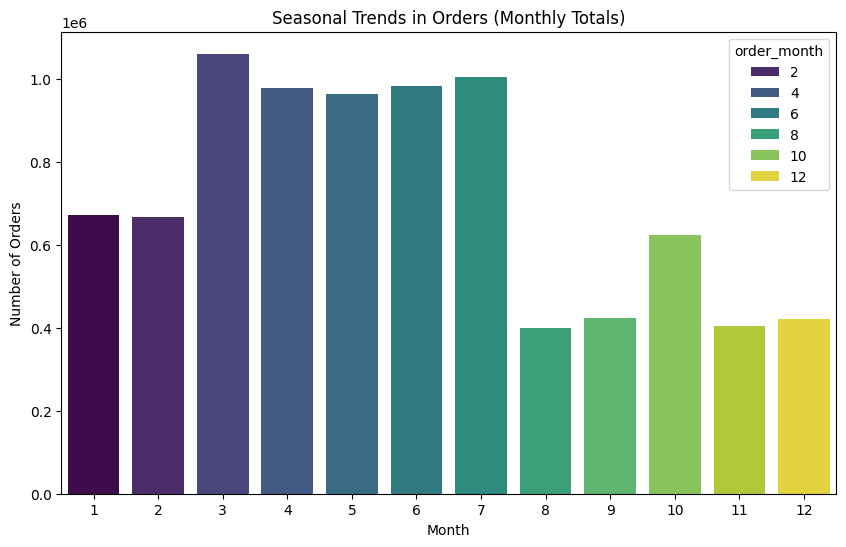

In [30]:
# Seasonal order trends
df_historical['order_month'] = df_historical['order_date'].dt.month
monthly_orders = df_historical.groupby('order_month').size().reset_index(name='num_orders')

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_orders, x='order_month', y='num_orders', palette='viridis', hue= "order_month" )
plt.title("Seasonal Trends in Orders (Monthly Totals)")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()

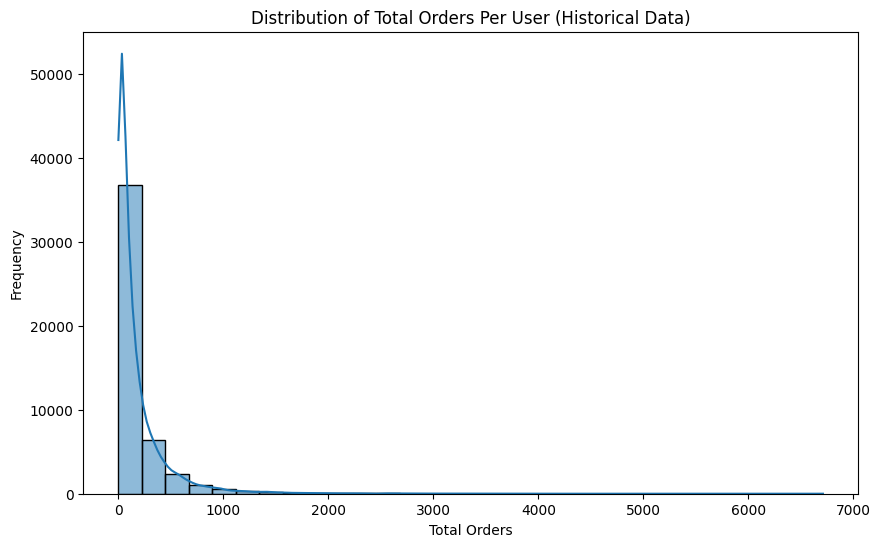

In [31]:
# Orders per user (overall)
orders_per_user = df_historical.groupby('account_id')['order_date'].count().reset_index(name='total_orders')

# Plot distribution of total orders per user
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_user['total_orders'], bins=30, kde=True)
plt.title("Distribution of Total Orders Per User (Historical Data)")
plt.xlabel("Total Orders")
plt.ylabel("Frequency")
plt.show()

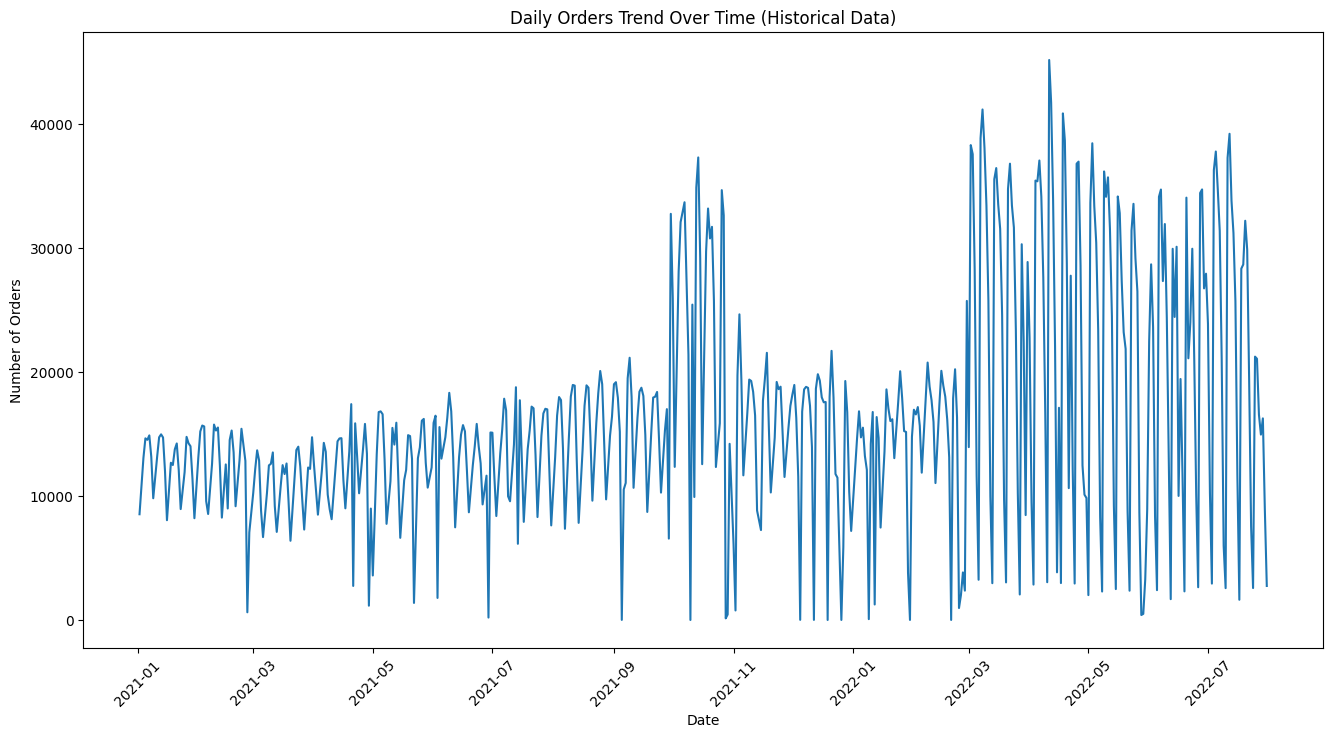

In [32]:
# Aggregating orders by date to see trends over time
daily_orders = df_historical.groupby('order_date').size().reset_index(name='num_orders')

# Plotting the time series of daily orders
plt.figure(figsize=(16, 8))
sns.lineplot(x='order_date', y='num_orders', data=daily_orders)
plt.title("Daily Orders Trend Over Time (Historical Data)")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


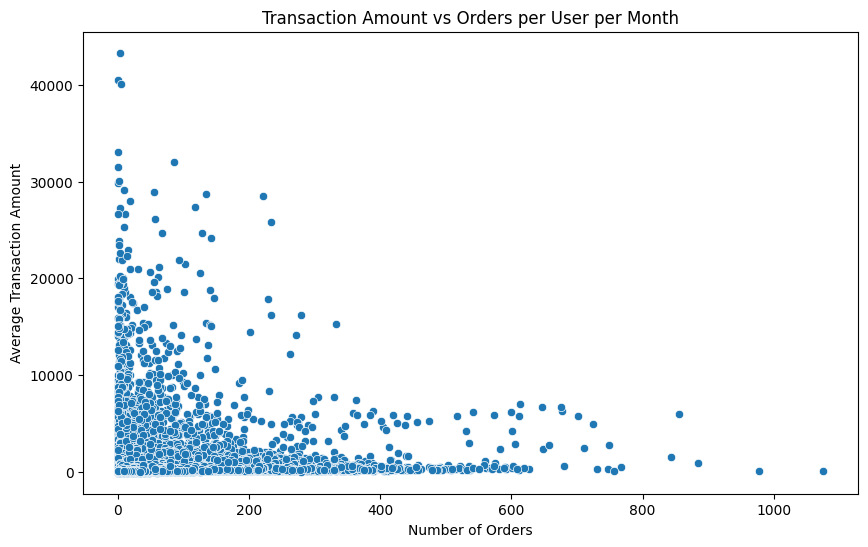

Correlation between number of orders and transaction amount: 0.10414568564255766


In [33]:
# Calculate average transaction amount per user per month
avg_transactions = df_historical.groupby(['account_id', 'order_month'])['transaction_amount'].mean().reset_index()

# Merge with orders per user per month
merged_data = pd.merge(orders_per_user_month, avg_transactions, on=['account_id', 'order_month'], how='left')

# Scatter plot to visualize correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='num_orders', y='transaction_amount')
plt.title("Transaction Amount vs Orders per User per Month")
plt.xlabel("Number of Orders")
plt.ylabel("Average Transaction Amount")
plt.show()

# Compute correlation
correlation = merged_data['num_orders'].corr(merged_data['transaction_amount'])
print(f"Correlation between number of orders and transaction amount: {correlation}")


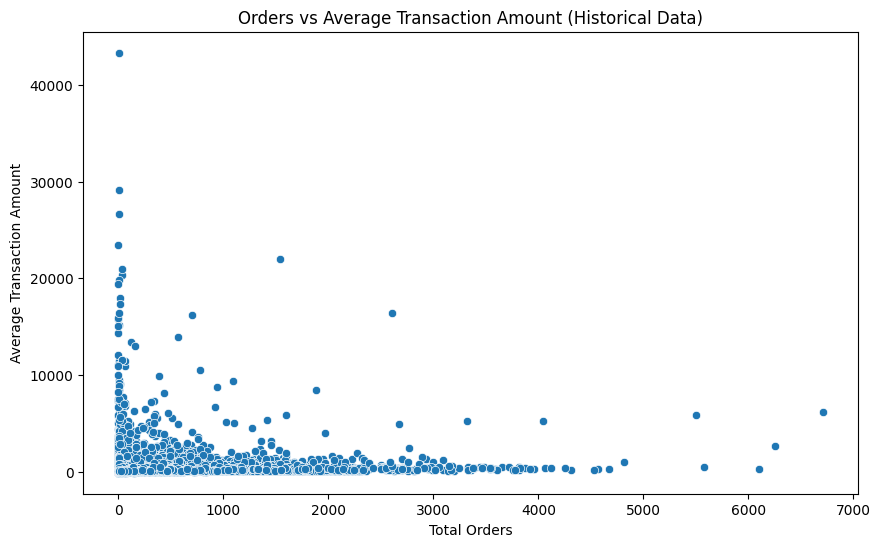

Correlation between total of orders and transaction amount: 0.08583303879225569


In [34]:
# Correlation between transaction amounts and frequency
user_avg_transaction = df_historical.groupby('account_id')['transaction_amount'].mean().reset_index()
merged_data = pd.merge(orders_per_user, user_avg_transaction, on='account_id')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='total_orders', y='transaction_amount')
plt.title("Orders vs Average Transaction Amount (Historical Data)")
plt.xlabel("Total Orders")
plt.ylabel("Average Transaction Amount")
plt.show()

# Compute correlation
correlation = merged_data['total_orders'].corr(merged_data['transaction_amount'])
print(f"Correlation between total of orders and transaction amount: {correlation}")

In [35]:
df_august_total_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       32944 non-null  object 
 1   total_transaction_amount_august  32944 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.9+ KB


In [36]:
# Check for missing data in df_august_total_sales
print("\nMissing values in df_august_total_sales:")
print(df_august_total_sales.isnull().sum())


Missing values in df_august_total_sales:
account_id                         0
total_transaction_amount_august    0
dtype: int64


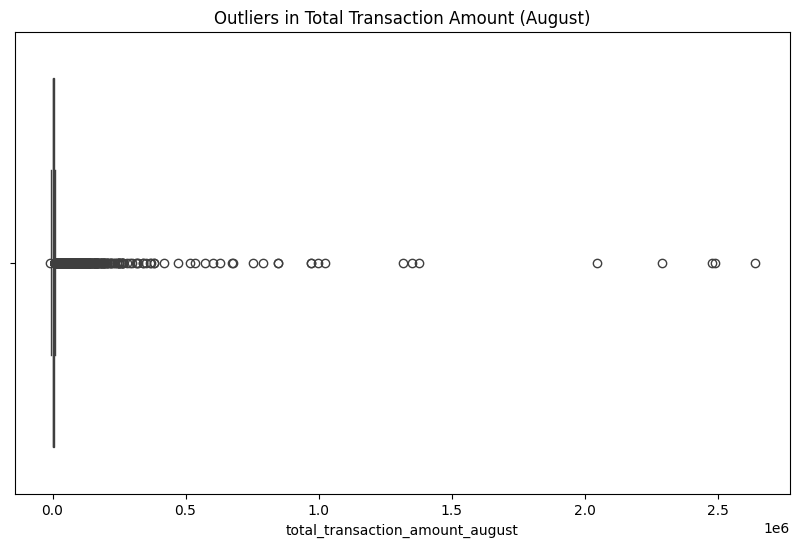

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_august_total_sales['total_transaction_amount_august'])
plt.title("Outliers in Total Transaction Amount (August)")
plt.show()

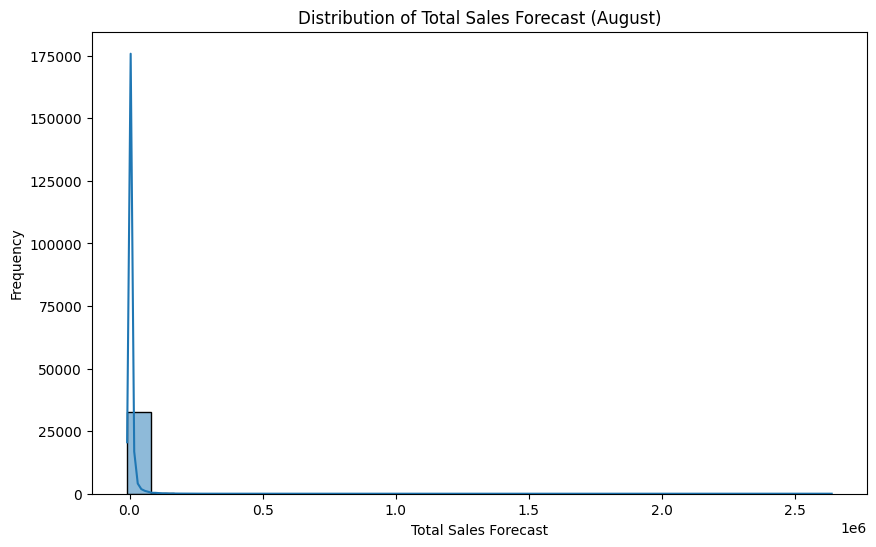

In [38]:
# Distribution of total sales forecast
plt.figure(figsize=(10, 6))
sns.histplot(df_august_total_sales['total_transaction_amount_august'], bins=30, kde=True)
plt.title("Distribution of Total Sales Forecast (August)")
plt.xlabel("Total Sales Forecast")
plt.ylabel("Frequency")
plt.show()

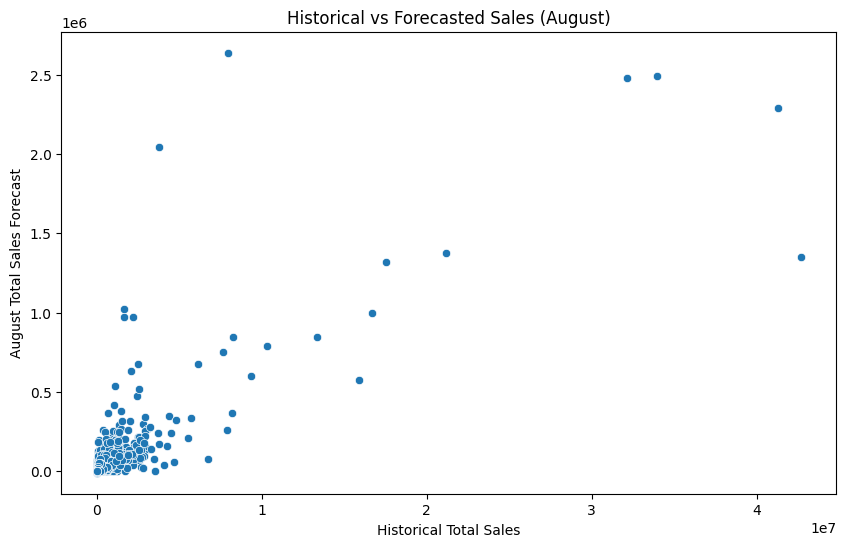

Correlation between historical and August forecasted sales: 0.8109958364028365


In [39]:
historical_total = df_historical.groupby('account_id')['transaction_amount'].sum().reset_index()
historical_total.columns = ['account_id', 'historical_total']

august_total_with_history = pd.merge(df_august_total_sales, historical_total, on='account_id', how='left')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=august_total_with_history, x='historical_total', y='total_transaction_amount_august')
plt.title("Historical vs Forecasted Sales (August)")
plt.xlabel("Historical Total Sales")
plt.ylabel("August Total Sales Forecast")
plt.show()

# Correlation coefficient
correlation = august_total_with_history['historical_total'].corr(august_total_with_history['total_transaction_amount_august'])
print(f"Correlation between historical and August forecasted sales: {correlation}")

- Order patterns over days in August.

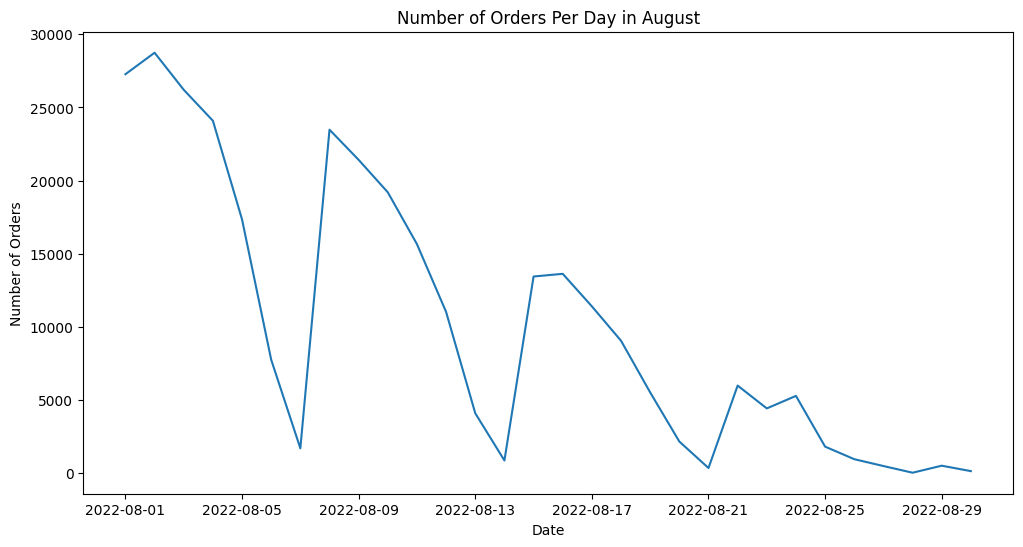

In [45]:
# Convert order_date to datetime for analysis
df_august_with_missing['order_date'] = pd.to_datetime(df_august_with_missing['order_date'], errors='coerce')

# Orders per day (count)
daily_orders_august = df_august_with_missing.groupby('order_date').size().reset_index(name='num_orders')

# Plot daily order counts
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_orders_august, x='order_date', y='num_orders')
plt.title("Number of Orders Per Day in August")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

In [46]:
# Analyze missing patterns
missing_dates = df_august_with_missing[df_august_with_missing['order_date'].isnull()]
print(f"Missing rows by account_id: {missing_dates['account_id'].value_counts().head()}")

Missing rows by account_id: Series([], Name: count, dtype: int64)


## Feature Engineering

- Aggregate historical data to generate user-level insights:

In [47]:
# Ensure order_date is datetime for temporal features
df_historical['order_date'] = pd.to_datetime(df_historical['order_date'], errors='coerce')

# Generate historical user-level features
historical_features = df_historical.groupby('account_id').agg(
    historical_total_orders=('order_date', 'count'),
    historical_avg_transaction=('transaction_amount', 'mean'),
    historical_total_transaction=('transaction_amount', 'sum'),
    first_order_date=('order_date', 'min'),
    last_order_date=('order_date', 'max')
).reset_index()

In [48]:
# Calculate user activity duration (days between first and last order)
historical_features['user_active_days'] = (
    historical_features['last_order_date'] - historical_features['first_order_date']
).dt.days + 1  # Add 1 to avoid dividing by zero

# Add order frequency (orders per active day)
historical_features['order_frequency'] = (
    historical_features['historical_total_orders'] / historical_features['user_active_days']
)

- Process df_august_with_missing

In [49]:
user_level_august = df_august_with_missing.groupby('account_id').agg(
    total_august_orders=('order_date', 'count'),
    avg_transaction_august=('transaction_amount', 'mean'),
    total_transaction_august=('transaction_amount', 'sum'),
    missing_order_days=('order_date', lambda x: x.isna().sum())
).reset_index()


In [50]:
# Group by order_date for day-level insights
grouped_by_day = df_august_with_missing.groupby('order_date').agg(
    total_transactions=('transaction_amount', 'sum'),
    num_orders=('transaction_amount', 'count')
).reset_index()

In [51]:
# Fill missing dates with zero transactions
all_days = pd.date_range('2022-08-01', '2022-08-31', freq='D')
grouped_by_day = grouped_by_day.set_index('order_date').reindex(all_days, fill_value=0).reset_index()
grouped_by_day.rename(columns={'index': 'order_date'}, inplace=True)

# Add cumulative transactions/orders and weekday feature
grouped_by_day['cumulative_orders'] = grouped_by_day['num_orders'].cumsum()
grouped_by_day['cumulative_transactions'] = grouped_by_day['total_transactions'].cumsum()
grouped_by_day['weekday'] = grouped_by_day['order_date'].dt.day_name()

- Process df_august_total_sales

In [52]:
# Add normalized total sales for August
df_august_total_sales['avg_transaction_per_day'] = (
    df_august_total_sales['total_transaction_amount_august'] / 31
)

- Calculate the Target (remaining_order_days)

In [53]:
# Total unique order days from august data
august_order_days = df_august_with_missing.groupby('account_id')['order_date'].nunique()

In [54]:
# Merge into a base dataset
base_dataset = df_august_total_sales.merge(user_level_august, on='account_id', how='left')
base_dataset = base_dataset.merge(historical_features, on='account_id', how='left')


In [55]:
# Estimate total order days in August
base_dataset['total_order_days_august'] = august_order_days
base_dataset['total_order_days_august'].fillna(
    base_dataset['historical_total_orders'] / base_dataset['user_active_days'] * 31, inplace=True
)

C:\Users\User\AppData\Local\Temp\ipykernel_17028\3068518245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_dataset['total_order_days_august'].fillna(


In [56]:
# Calculate remaining order days
base_dataset['remaining_order_days'] = (
    base_dataset['total_order_days_august'] - base_dataset['total_august_orders']
)


In [57]:
# Handle users with missing data
base_dataset['remaining_order_days'] = base_dataset['remaining_order_days'].fillna(
    base_dataset['total_transaction_amount_august'] / base_dataset['avg_transaction_august']
)

In [58]:
# Clip remaining order days between 0 and 31
base_dataset['remaining_order_days'] = base_dataset['remaining_order_days'].clip(lower=0, upper=31)


- Merge All Data for Final Dataset

In [59]:
# Pivot grouped_by_day to create columns for each day of August
pivot_grouped_by_day = grouped_by_day.pivot_table(
    index='order_date',
    values=['total_transactions', 'num_orders', 'cumulative_orders', 'cumulative_transactions', 'weekday'],
    aggfunc='sum'
)

# Reset index to use as features in final dataset
pivot_grouped_by_day.reset_index(inplace=True)

# Ensure order_date is datetime
pivot_grouped_by_day['order_date'] = pd.to_datetime(pivot_grouped_by_day['order_date'])

# Now, pivot the 'grouped_by_day' for daily order features, which can be merged with users
pivot_grouped_by_day.head()


,order_date,cumulative_orders,cumulative_transactions,num_orders,total_transactions,weekday
0,2022-08-01,27274,7339626.58,27274,7339626.58,Monday
1,2022-08-02,56017,15208514.75,28743,7868888.17,Tuesday
2,2022-08-03,82228,21550075.92,26211,6341561.17,Wednesday
3,2022-08-04,106324,27412610.35,24096,5862534.43,Thursday
4,2022-08-05,123675,31926064.17,17351,4513453.82,Friday


In [60]:
# Create a pivot table for user-day level interactions
pivot_table = df_august_with_missing.pivot_table(
    index='account_id',
    columns='order_date',
    values='transaction_amount',
    aggfunc='sum',
    fill_value=0
)

In [61]:
# Add total August transactions as a feature
pivot_table['total_august_transactions'] = pivot_table.sum(axis=1)

# Merge with base dataset
final_dataset = base_dataset.merge(pivot_table.reset_index(), on='account_id', how='left')


In [62]:
# Ensure 'account_id' is a string type in final_dataset
final_dataset['account_id'] = final_dataset['account_id'].astype(str)

# Convert 'order_date' to string type in pivot_grouped_by_day for proper merging
pivot_grouped_by_day['order_date'] = pivot_grouped_by_day['order_date'].dt.strftime('%Y-%m-%d')

# Merge final_dataset with pivot_grouped_by_day on 'account_id' (converted to string) and 'order_date' (also converted to string)
final_dataset_with_grouped = final_dataset.merge(
    pivot_grouped_by_day[['order_date', 'total_transactions', 'num_orders', 'cumulative_orders', 'cumulative_transactions', 'weekday']],
    left_on='account_id', right_on='order_date', how='left'
)

# Drop 'order_date' after the merge as it's no longer needed
final_dataset_with_grouped.drop(columns=['order_date'], inplace=True)

# Inspect the merged data
final_dataset_with_grouped



,account_id,total_transaction_amount_august,avg_transaction_per_day,total_august_orders,avg_transaction_august,total_transaction_august,missing_order_days,historical_total_orders,historical_avg_transaction,historical_total_transaction,...,2022-08-27 00:00:00,2022-08-28 00:00:00,2022-08-29 00:00:00,2022-08-30 00:00:00,total_august_transactions,total_transactions,num_orders,cumulative_orders,cumulative_transactions,weekday
0,BR_00000343803,309.99,9.999677,NaN,NaN,NaN,NaN,157.0,117.466433,18442.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BR_00001415930,874.98,28.225161,NaN,NaN,NaN,NaN,31.0,71.545806,2217.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BR_00001760106,11976.70,386.345161,NaN,NaN,NaN,NaN,273.0,132.786300,36250.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BR_00002485176,511.48,16.499355,7.0,46.854286,327.98,0.0,38.0,57.331579,2178.60,...,0.0,0.0,0.0,0.0,327.98,NaN,NaN,NaN,NaN,NaN
4,BR_00002536340,7081.14,228.423871,3.0,779.586667,2338.76,0.0,55.0,859.124364,47251.84,...,0.0,0.0,0.0,0.0,2338.76,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32939,BR_99904403791,2996.69,96.667419,NaN,NaN,NaN,NaN,227.0,185.742026,42163.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32940,BR_99910241587,4225.98,136.321935,NaN,NaN,NaN,NaN,154.0,67.463117,10389.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32941,BR_99936259300,646.44,20.852903,2.0,89.900000,179.80,0.0,90.0,96.730222,8705.72,...,0.0,0.0,0.0,0.0,179.80,NaN,NaN,NaN,NaN,NaN
32942,BR_99946866587,494.36,15.947097,NaN,NaN,NaN,NaN,53.0,47.799623,2533.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
print(final_dataset_with_grouped.isnull().sum())

account_id                             0
total_transaction_amount_august        0
avg_transaction_per_day                0
total_august_orders                13438
avg_transaction_august             13438
total_transaction_august           13438
missing_order_days                 13438
historical_total_orders             1223
historical_avg_transaction          1223
historical_total_transaction        1223
first_order_date                    1223
last_order_date                     1223
user_active_days                    1223
order_frequency                     1223
total_order_days_august             1223
remaining_order_days               13439
2022-08-01 00:00:00                13438
2022-08-02 00:00:00                13438
2022-08-03 00:00:00                13438
2022-08-04 00:00:00                13438
2022-08-05 00:00:00                13438
2022-08-06 00:00:00                13438
2022-08-07 00:00:00                13438
2022-08-08 00:00:00                13438
2022-08-09 00:00

#### Outlier Detection and Treatment

#### Analyzing the Target

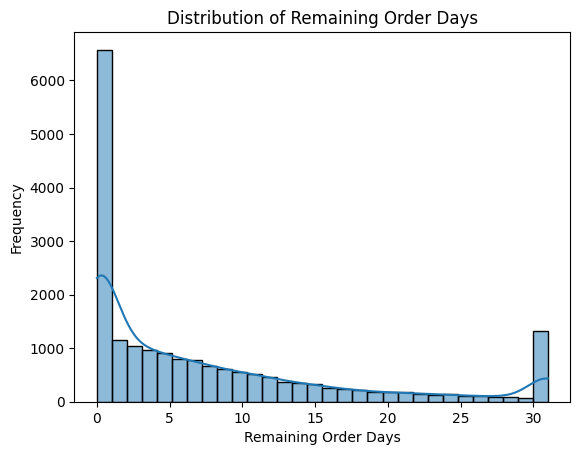

In [64]:
# Plot the distribution of the target
sns.histplot(final_dataset_with_grouped['remaining_order_days'], kde=True, bins=30)
plt.title('Distribution of Remaining Order Days')
plt.xlabel('Remaining Order Days')
plt.ylabel('Frequency')
plt.show()

In [65]:
# Quantiles to identify extreme values
lower_bound = final_dataset_with_grouped['remaining_order_days'].quantile(0.01)  # 1st percentile
upper_bound = final_dataset_with_grouped['remaining_order_days'].quantile(0.99)  # 99th percentile

print(f"Lower Bound (1%): {lower_bound}")
print(f"Upper Bound (99%): {upper_bound}")

Lower Bound (1%): 0.0
Upper Bound (99%): 31.0


In [66]:
final_dataset_with_grouped['remaining_order_days'] = final_dataset['remaining_order_days'].clip(lower=lower_bound, upper=upper_bound)


#### Analyzing and Treating Outliers in Numerical Features


In [67]:
# Define numerical columns excluding the target
numerical_cols = final_dataset_with_grouped.select_dtypes(include=['float64']).columns
numerical_cols = numerical_cols.drop('remaining_order_days')  # Exclude the target

In [68]:
# Detect and cap outliers
for col in numerical_cols:
    lower = final_dataset_with_grouped[col].quantile(0.01)  # 1st percentile
    upper = final_dataset_with_grouped[col].quantile(0.99)  # 99th percentile
    # Explicitly use .loc for column assignment
    final_dataset_with_grouped.loc[:, col] = final_dataset_with_grouped[col].clip(lower=lower, upper=upper)
    
    print(f"Capped outliers for {col} between {lower} and {upper}")
    print("")


Capped outliers for total_transaction_amount_august between 12.0 and 71316.905

Capped outliers for avg_transaction_per_day between 0.3870967741935484 and 2300.545322580645

Capped outliers for total_august_orders between 1.0 and 93.0

Capped outliers for avg_transaction_august between 19.44014285714286 and 1950.8202272727297

Capped outliers for total_transaction_august between 42.726 and 53099.30400000017

Capped outliers for missing_order_days between 0.0 and 0.0

Capped outliers for historical_total_orders between 3.1999999999999886 and 1602.3999999999978

Capped outliers for historical_avg_transaction between 15.280714727996461 and 1444.8937555592352

Capped outliers for historical_total_transaction between 139.31599999999997 and 811553.8139999978

Capped outliers for user_active_days between 1.0 and 574.0

Capped outliers for order_frequency between 0.046511627906976744 and 4.0

Capped outliers for total_order_days_august between 1.441860465116279 and 124.0

Capped outliers for 2

#### Special Case: Date Columns

In [69]:
# Example: Days active
final_dataset_with_grouped.loc[:, 'days_between_orders'] = (
    final_dataset_with_grouped['last_order_date'] - final_dataset_with_grouped['first_order_date']
).dt.days

### Data Cleaning 

In [70]:
final_dataset_with_grouped.isnull().sum()


account_id                             0
total_transaction_amount_august        0
avg_transaction_per_day                0
total_august_orders                13438
avg_transaction_august             13438
total_transaction_august           13438
missing_order_days                 13438
historical_total_orders             1223
historical_avg_transaction          1223
historical_total_transaction        1223
first_order_date                    1223
last_order_date                     1223
user_active_days                    1223
order_frequency                     1223
total_order_days_august             1223
remaining_order_days               13439
2022-08-01 00:00:00                13438
2022-08-02 00:00:00                13438
2022-08-03 00:00:00                13438
2022-08-04 00:00:00                13438
2022-08-05 00:00:00                13438
2022-08-06 00:00:00                13438
2022-08-07 00:00:00                13438
2022-08-08 00:00:00                13438
2022-08-09 00:00

#### Deaing with missing value in target 

In [71]:
# Define features and target
features = ['total_august_orders', 'historical_total_orders', 'total_transaction_august']
target = 'remaining_order_days'

# Separate the data into known and missing parts
known_data = final_dataset_with_grouped.dropna(subset=features + [target])  # Rows with complete data
missing_data = final_dataset_with_grouped[final_dataset_with_grouped[target].isnull()]  # Rows with missing target

# Initialize the HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()

# Fit the model
model.fit(known_data[features], known_data[target])

# Predict missing target values in the missing_data
predicted_values = model.predict(missing_data[features])

# Update the original dataset with the predicted target values for missing data
final_dataset_with_grouped.loc[final_dataset_with_grouped[target].isnull(), target] = predicted_values


In [72]:
# Check for columns with all missing values
empty_columns = final_dataset_with_grouped.isnull().sum()
completely_empty_columns = empty_columns[empty_columns == len(final_dataset_with_grouped)]
print(completely_empty_columns)


total_transactions         32944
num_orders                 32944
cumulative_orders          32944
cumulative_transactions    32944
weekday                    32944
dtype: int64


In [73]:
final_dataset_with_grouped = final_dataset_with_grouped.drop(
    columns=['total_transactions', 'num_orders', 'cumulative_orders', 'cumulative_transactions', 'weekday']
)


In [74]:
# Impute missing numerical features with the median
numerical_columns = [
    'total_august_orders', 'avg_transaction_august', 'total_transaction_august',
    'historical_total_orders', 'historical_avg_transaction', 'historical_total_transaction',
    'user_active_days', 'order_frequency', 'total_order_days_august', 'remaining_order_days',
    'total_august_transactions', 'days_between_orders'
]

for col in numerical_columns:
    # Fill missing values with the median of the column
    median_value = final_dataset_with_grouped[col].median()
    final_dataset_with_grouped[col] = final_dataset_with_grouped[col].fillna(median_value)

In [75]:

# Impute missing datetime features (e.g., 'first_order_date' and 'last_order_date') with the most frequent date or drop rows
final_dataset_with_grouped['first_order_date'] =final_dataset_with_grouped['first_order_date'].fillna(final_dataset_with_grouped['first_order_date'].mode()[0])
final_dataset_with_grouped['last_order_date'] = final_dataset_with_grouped['last_order_date'].fillna(final_dataset_with_grouped['last_order_date'].mode()[0])

# Check if any missing values remain
final_dataset_with_grouped = final_dataset_with_grouped.fillna(0)


#### Preprocessing the Data

In [77]:
# Identify numeric features for scaling
numerical_features = [
    'total_transaction_amount_august', 'avg_transaction_per_day', 'total_august_orders',
    'avg_transaction_august', 'total_transaction_august', 'missing_order_days', 
    'historical_total_orders', 'historical_avg_transaction', 'historical_total_transaction',
    'user_active_days', 'order_frequency', 'total_order_days_august', 'remaining_order_days',
    'total_august_transactions', 'days_between_orders'
]

# Initialize scalers
scaler = StandardScaler()

# Apply scaler to numerical features
final_dataset_with_grouped[numerical_features] = scaler.fit_transform(final_dataset_with_grouped[numerical_features])

In [78]:
# Check for datetime columns
datetime_columns = final_dataset_with_grouped.select_dtypes(include=['datetime64']).columns
print("Datetime columns:", datetime_columns)


Datetime columns: Index(['first_order_date', 'last_order_date'], dtype='object')


In [79]:
for col in datetime_columns:
    final_dataset_with_grouped[col + '_days_since_start'] = (final_dataset_with_grouped[col] - pd.Timestamp("2022-01-01")).dt.days

In [80]:
final_dataset_with_grouped = final_dataset_with_grouped.drop(columns=datetime_columns)

## Modeling 

#### Train, Test, and Validation Split

In [81]:
# Split the dataset into features (X) and target variable (y)
X = final_dataset_with_grouped.drop(columns=['account_id', 'remaining_order_days'])  # Drop the target column
y = final_dataset_with_grouped['remaining_order_days']  # Target variable

# First, split into training + validation and test sets (80% train + validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the training + validation set into training and validation (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

# Check the sizes of the splits
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')


Training set size: 18448
Validation set size: 7907
Test set size: 6589


In [82]:
# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


### Trainning

In [83]:
# Define all models, including CatBoost
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVR": SVR()
}

In [84]:

# Data structures to store results
trained_models = {}
validation_metrics = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    validation_metrics[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }


In [85]:
# Create DataFrame from validation metrics
validation_df = pd.DataFrame(validation_metrics).T.sort_values(by="MAE")

# Display validation metrics
print(validation_df)


                        MAE      RMSE        R²
Random Forest      0.027454  0.123109  0.984273
CatBoost           0.057277  0.134717  0.981168
XGBoost            0.061828  0.145049  0.978168
Gradient Boosting  0.211871  0.331695  0.885833
Linear Regression  0.437345  0.615164  0.607316
Ridge              0.437363  0.615242  0.607216
SVR                0.563375  0.899421  0.160563
Lasso              0.657531  0.929592  0.103301


### Tunning

In [86]:
# # Random Forest parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],  # Number of trees
#     'max_depth': [10, 20, 30, None],        # Max depth of trees
#     'min_samples_split': [2, 5, 10],        # Min samples required to split node
#     'min_samples_leaf': [1, 2, 4],          # Min samples required at leaf node
#     'max_features': [ 'sqrt', 'log2']  # Max features to consider for each split
# }

# # Initialize the Random Forest model
# rf_model = RandomForestRegressor(random_state=42)

# # Set up GridSearchCV for hyperparameter optimization
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5, 
#     scoring='neg_root_mean_squared_error',  # Métrica de avaliação
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)


# best_model = grid_search.best_estimator_
# print("Melhores parâmetros:", grid_search.best_params_)
# print("Desempenho no conjunto de validação:", -grid_search.best_score_)


#### Final trainning

In [87]:
# Train the model
model = RandomForestRegressor(n_estimators= 500, min_samples_split = 2, min_samples_leaf = 1, max_features =  'sqrt', max_depth = 30, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [88]:
# Predict remaining order days on the validation set
y_pred_val = model.predict(X_val)


In [89]:
# Evaluate the model on the validation set
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print(f"Validation MAE: {mae_val:.4f}, Validation RMSE: {rmse_val:.4f}, Validation R²: {r2_val:.4f}")

Validation MAE: 0.1364, Validation RMSE: 0.2636, Validation R²: 0.9279


In [91]:
# Predict on the test set
y_pred_test = model.predict(X_test)

# Evaluate performance on the test set

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MAE: {mae_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R²: {r2_test:.4f}")

Test MAE: 0.1436
Test RMSE: 0.2793
Test R²: 0.9249


### Predicting new datas

In [92]:
# Load the datasets
df_historical = pd.read_parquet('historical_orders.parquet')
df_august_total_sales = pd.read_parquet('august_total_sales.parquet')
df_august_with_missing = pd.read_parquet('august_with_missing_order_days.parquet')

In [94]:
X = final_dataset_with_grouped.drop(columns=['account_id', 'remaining_order_days'])  # Drop the target column
X.columns = X.columns.astype(str)

# Predict on the test set
predicoes = model.predict(X)



In [96]:
#Checking unique ID's
final_dataset_with_grouped["account_id"].nunique()

32944

In [ ]:
#Checking unique ID's
df_august_with_missing["account_id"].nunique()

32944

In [99]:
#Setting Scaler 
scaler_target = StandardScaler()
target_column = 'remaining_order_days'

In [ ]:
# Adjusting scaler for only the target
scaler_target.fit(final_dataset_with_grouped[[target_column]])

StandardScaler()

In [101]:
#Reversing the target after the predict
predicoes_target = predicoes.reshape(-1, 1)
predicoes_target_revertidas = scaler_target.inverse_transform(predicoes_target)

In [102]:
# Making the new datadrame
order_days_prediction = pd.DataFrame({
    'user_id': final_dataset_with_grouped['account_id'],  
    'predicao': predicoes_target_revertidas.flatten() #remove extra dimension
},  index=final_dataset_with_grouped.index)

# Saving to csv
order_days_prediction.to_csv('order_days_prediction.csv', index=False)

array([[<Axes: title={'center': 'predicao'}>]], dtype=object)

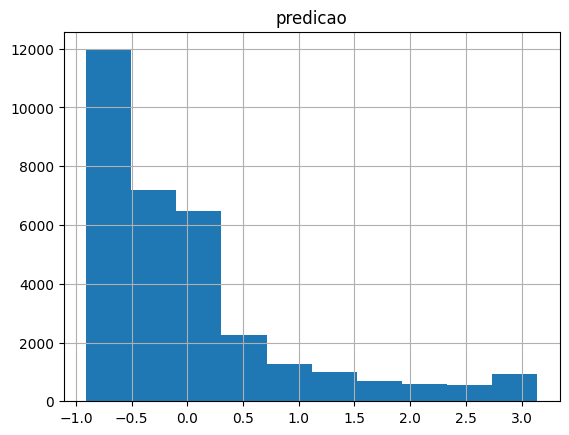

In [103]:
order_days_prediction.hist()

In [ ]:
# Saving the model 
joblib.dump(model, 'modelo_treinado.joblib')

# Loading the model 
#modelo_carregado = joblib.load('modelo_treinado.joblib')

['modelo_treinado.joblib']

# Question 2

### Imports 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import lognorm
from scipy import stats


### 2-a

In [158]:
order_days= final_dataset_with_grouped.remaining_order_days

# Estimate the parameter lambda using MLE
# For exponential distribution, 1/lambda is the mean of the data
lambda_estimate = 1 / np.mean(order_days[order_days > 0])  # Avoid negative values if they exist


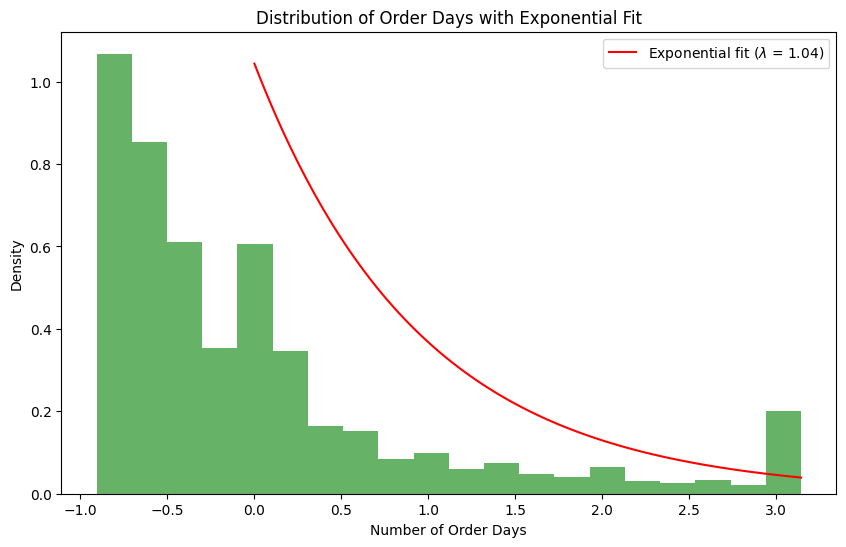

In [162]:
# Plot the histogram and fitted exponential distribution
plt.figure(figsize=(10, 6))
# Plot histogram of data
plt.hist(order_days, bins=20, density=True, alpha=0.6, color='g')

# Plot the PDF of estimated exponential distribution
x = np.linspace(0, np.max(order_days), 100)
pdf = expon.pdf(x, scale=1/lambda_estimate)
plt.plot(x, pdf, 'r-', label=f'Exponential fit ($\lambda$ = {lambda_estimate:.2f})')

plt.title('Distribution of Order Days with Exponential Fit')
plt.xlabel('Number of Order Days')
plt.ylabel('Density')
plt.legend()
plt.show()

 **Data Fitting:** The script fits an exponential distribution to the data by estimating \(\lambda\), the rate parameter, using the inverse of the mean of the data.
- **Model Visualization:** The histogram of the data is plotted with the exponential PDF overlaid, allowing you to visually assess the fit.

### Considerations

- **Data Assumptions:** The assumption here is that the number of order days can be modeled by an exponential distribution, which might not be the case if the data has significant negative values or if the specific domain context violates these assumptions.
- **Model Evaluation:** Evaluate the goodness of fit by comparing actual data against the fitted distribution using statistical tests such as the Kolmogorov-Smirnov test.

By following these steps, you can model the distribution of order days and establish an understanding of order behavior using an appropriate probability distribution.

In [165]:
# Apply a constant offset to make data positive if necessary
data = np.array(order_days) + np.abs(np.min(order_days)) + 1  # Make data strictly positive

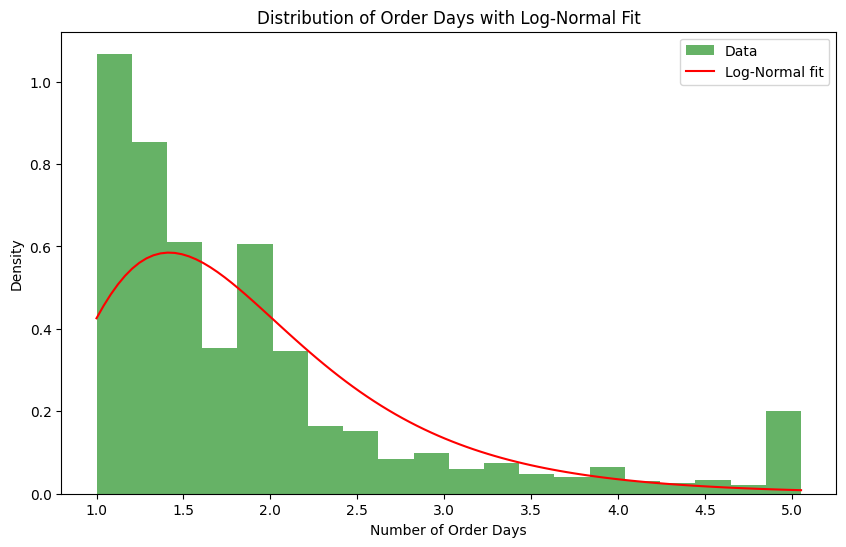

In [166]:
# Estimate the parameters for log-normal distribution
shape, loc, scale = lognorm.fit(data, floc=0)

# Plot the histogram and log-normal fit
plt.figure(figsize=(10, 6))
plt.hist(data, bins=20, density=True, alpha=0.6, color='g', label='Data')

# Plot the PDF of estimated log-normal distribution
x = np.linspace(np.min(data), np.max(data), 100)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r-', label=f'Log-Normal fit')

plt.title('Distribution of Order Days with Log-Normal Fit')
plt.xlabel('Number of Order Days')
plt.ylabel('Density')
plt.legend()
plt.show()


In [171]:
# Kolmogorov-Smirnov Test
ks_statistic, ks_p_value = stats.kstest(data, 'lognorm', args=(shape, loc, scale))
print(f"K-S Test Statistic: {ks_statistic}, p-value: {ks_p_value}")


# Chi-Square (if applicable for binned data)
# Manually define bins or use histogram bin edges:
hist, bin_edges = np.histogram(data, bins=10, density=True)
expected_freq = len(data) * np.diff(bin_edges) * stats.lognorm.pdf(bin_edges[:-1], shape, loc, scale)
chi_square_stat = np.sum((hist - expected_freq) ** 2 / expected_freq)
print(f"Chi-Square Test Statistic: {chi_square_stat}")

K-S Test Statistic: 0.10847895600733437, p-value: 0.0
Chi-Square Test Statistic: 31564.6106038975


### Interpretation of Results

#### Kolmogorov-Smirnov (K-S) Test

- **K-S Test Statistic: 0.1085**
  - This statistic measures the largest distance between the empirical distribution function of the sample data and the cumulative distribution function of the fitted log-normal distribution.

- **p-value: 0.0**
  - A p-value of 0.0 indicates that the difference between the observed data and the log-normal distribution is statistically significant. This suggests a poor fit — the data deviates significantly from what the log-normal distribution predicts.

#### Chi-Square Test

- **Chi-Square Statistic: 31564.61**
  - This statistic compares observed frequencies with expected frequencies based on the fitted distribution. A high value indicates substantial discrepancies between the observed data and the model’s predictions.

### Explanation and Next Steps

1. **Model Fit Assessment:**
   - The statistical results indicate that the log-normal distribution may not be capturing the data's characteristics accurately. While initial visual inspections might suggest a reasonable fit, statistical tests provide a more rigorous analysis.

2. **Alternative Models:**
   - **Explore Other Distributions:** Consider fitting other distributions like gamma, Weibull, or mixtures of distributions if there are distinct subgroups within the data.
   - **Data Transformation:** Further transform the data if there are structural issues (e.g., heavy tails or multimodal distribution).

3. **Resampling and Cross-Validation:**
   - **Cross-Validation:** Validate the model's performance using different subsets of the data. This can prevent overfitting and ensure the chosen model's robustness.

4. **Additional Data Exploration:**
   - **Outlier Analysis:** Examine potential outliers or data errors that might skew results.
   - **Cluster Analysis:** Identify distinct patterns or clusters in the data, which could suggest the need for separate models.

In summary, while the log-normal model appeared visually promising, the statistical results indicate that further exploration is needed to identify a more suitable model for the data. Using a combination of statistical tests and alternative modeling techniques can improve the understanding and prediction of order days.

### 2-b

In [175]:
order_days= final_dataset_with_grouped.remaining_order_days
data = np.array(order_days) + np.abs(np.min(order_days)) + 1  # Ensure positivity


In [176]:
# Fit log-normal distribution
shape, loc, scale = lognorm.fit(data, floc=0)
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

Shape: 0.4372579402764399, Location: 0, Scale: 1.7157733261729502


- **Shape (σ)**: Represents the standard deviation of the log-transformed variable. It indicates the distribution's spread.
- **Location (loc)**: For log-normal, it's typically set to zero.
- **Scale (exp(μ))**: Represents a transformed mean of the log-transformed data, determining the scale of the distribution in its original form.

### 2-c

In [ ]:
# Calculate probability of having more than 4 days of orders
   
probability_more_than_4 = 1 - lognorm.cdf(4, shape, loc, scale)
print(f"Probability of more than 4 days of orders: {probability_more_than_4}")

Probability of more than 4 days of orders: 0.026447986005192603


The calculated probability of having more than 4 days of orders is approximately **0.0264**. This means there's about a 2.64% chance of experiencing more than 4 days between orders, given the fitted log-normal distribution. This low probability suggests that such occurrences are relatively rare.

### 2-d

In [179]:
#Calculate Mean and Variance**:


# Calculate mean of the log-normal distribution
mu = np.log(scale)  # Corresponding mu for the log-transformed normal distribution
sigma = shape       # Corresponding sigma (shape parameter for log-normal)

# Mean of the log-normal distribution
mean_time_between_orders = np.exp(mu + (sigma**2) / 2)
print(f"Mean time between orders: {mean_time_between_orders}")

# Variance of the log-normal distribution (optional, for variability insights)
variance_time_between_orders = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
print(f"Variance in time between orders: {variance_time_between_orders}")

Mean time between orders: 1.8878925446679402
Variance in time between orders: 0.7509458149537922


- **Mean Time Between Orders**: Approximately **1.89 days**. This represents the average number of days expected between order events.
  
- **Variance in Time Between Orders**: Approximately **0.75**. This measures the amount of variability or spread in the time between orders, indicating how much individual occurrences may differ from the mean.

These insights help in understanding the typical order cycle and its variability.